# CNN Regression Model

In [1]:
import pandas as pd
from Data_preparation_Library import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from random import choice
from scipy import signal
from pickle import load,dump
import math
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras import backend as K

## Sample

<AxesSubplot:title={'center':'Velocity'}>

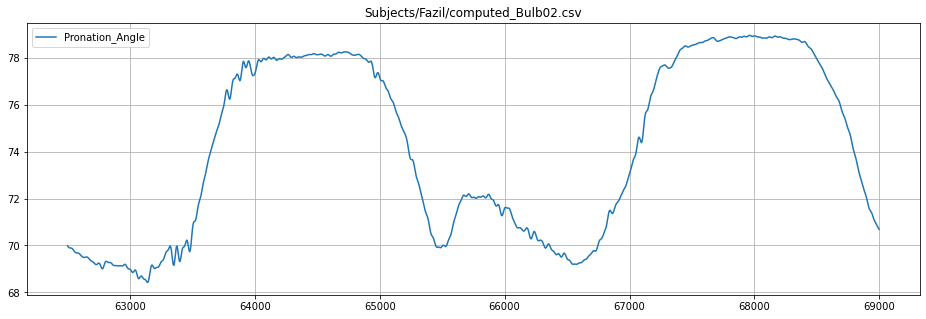

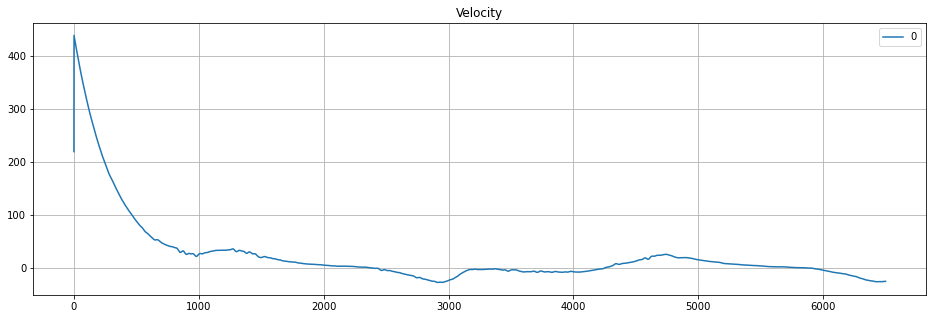

In [2]:
file = 'Subjects/Fazil/computed_Bulb02.csv'
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']
angle_lables = ['Pronation_Angle'] # 'Pronation_Angle','Flexion_Angle',  'Radial_Angle','Elbow_Joint_Angle'
df = pd.read_csv(file,index_col=0)[62500:69000]#[4500:85000]#[72500:82500]
df[angle_lables].plot(figsize=(16,5),title=file,grid=True)

arr = np.diff([0]+list(df['Pronation_Angle']))
arr = arr/(1/2000)
b,a = signal.butter(1, 1,fs=2000)
arr = signal.lfilter(b, a,arr)
pd.DataFrame(arr).plot(figsize=(16,5),title='Velocity',grid=True)

## Prep Data

In [39]:
window = 250

In [30]:
files = []
# subjects = ['Fazil','Nikhil','Ingy','Abhishek','Jai', 'Deepti', 'Nirmayee'] #'Fazil/day_04_14_21' ,'Varun'
subjects = ['Varun'] #'Fazil/day_04_14_21' ,'Varun'
for subj in subjects:
    path = 'Subjects/'+subj
    trial_names = ['Bulb','Screw'] # 'Bulb','Hammer' ,'Cup','Screw'
#     trial_names = ['Bulb','Screw','Hammer' ,'Cup',] #
    for exp in trial_names:
        for i in range(3):
            if(i==0):
                files.append(path+'/computed_'+exp+'.csv')
            else:
                files.append(path+'/computed_'+exp+'0'+str(i)+'.csv')
files

['Subjects/Varun/computed_Bulb.csv',
 'Subjects/Varun/computed_Bulb01.csv',
 'Subjects/Varun/computed_Bulb02.csv',
 'Subjects/Varun/computed_Screw.csv',
 'Subjects/Varun/computed_Screw01.csv',
 'Subjects/Varun/computed_Screw02.csv']

In [31]:
files_df = []
for file in files:
    files_df.append(pd.read_csv(file,index_col=0))#[4500:85000])

In [32]:
files_df = filter_df(files_df)

### Remove Test Reps Data

In [40]:
test_rep_files = ['Subjects/Fazil/computed_Bulb02.csv', 
                  'Subjects/Fazil/computed_Screw02.csv']
tr_range = [29000,37000]

In [88]:
files_df = []
for file in files:
    if file in test_rep_files:
        df = pd.read_csv(file,index_col=0)[4500:85000]
        df = df.drop(df.index[tr_range[0]:tr_range[1]])
    else:
        df = pd.read_csv(file,index_col=0)[4500:85000]
    files_df.append(df)
files_df = filter_df(files_df)

### Only Removed Reps

In [41]:
files_df = []
files = test_rep_files
for file in files:
    df = pd.read_csv(file,index_col=0)
    files_df.append(df[tr_range[0]:tr_range[1]])
files_df = filter_df(files_df)

F:\The Stuffs\Awear\Final_Project\wrist_data_collection_AWEAR\Data_preparation_Library.py:467: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  files_df[i][emg_labels] = np.array(emg_df)
C:\Users\moham\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


## Rearrange

In [89]:
from collections import deque
rearr_labels = []
labels = deque(emg_labels)
labels.rotate(1)
rearr_labels.append(list(labels))
labels.rotate(-2)
rearr_labels.append(list(labels))
rearr_labels

[['EMG8', 'EMG1', 'EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7'],
 ['EMG2', 'EMG3', 'EMG4', 'EMG5', 'EMG6', 'EMG7', 'EMG8', 'EMG1']]

In [90]:
files_df_rearrange = []
for df in tqdm(files_df):
    for lb in rearr_labels:
        df[emg_labels] = df[lb]
        files_df_rearrange.append(df) 
    
files_df = files_df+files_df_rearrange
len(files_df)

126

## Generate Training Data

In [42]:
X, y = multiple_prep_data_velocity(files_df,window,interval=10,Normalize=True,rms=False,angle_label ='Pronation_Angle')
X.shape

(1550, 250, 8)

## Time Window Normalize

In [34]:
X_mean = np.zeros(X[0].shape)
for x in X:
    X_mean = X_mean + x
X_mean = X_mean/X.shape[0]
X_std = np.sqrt(variance(X))
np.save('mean_std',np.array([X_mean,X_std]))

In [32]:
X_mean = np.load('mean_std_master.npy')[0]
X_std = np.load('mean_std_master.npy')[1]

In [33]:
X_new = []
for x in tqdm(X):
    X_new.append((x-X_mean)/X_std)
X = np.array(X_new)

## Test Train Split

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
for data in [X_train, X_test, y_train, y_test]:
    print(data.shape)

(648840, 250, 8)
(162210, 250, 8)
(648840, 1)
(162210, 1)


In [94]:
np.save('prepared_data/X_train',X_train)
np.save('prepared_data/X_test',X_test)
np.save('prepared_data/y_train',y_train)
np.save('prepared_data/y_test',y_test)

In [10]:
X_train = np.load('prepared_data/X_train.npy')
X_test = np.load('prepared_data/X_test.npy')
y_train = np.load('prepared_data/y_train.npy')
y_test = np.load('prepared_data/y_test.npy')

In [36]:
for data in [X_train, X_test, y_train, y_test]:
    print(data.shape)

(648840, 250, 8)
(162210, 250, 8)
(648840, 1)
(162210, 1)


# Neural Network Regression

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
n_outputs = 1

In [44]:
n_outputs = 1
filter_size = 3
in_shape = (X_train.shape[1],X_train.shape[2])

model = Sequential()

model.add(Conv1D(filters=256, kernel_size=filter_size, activation='relu', input_shape=in_shape))
model.add(Conv1D(filters=256, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=256, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=256, kernel_size=filter_size, activation='relu'))

model.add(Conv1D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=filter_size, activation='relu'))

# model.add(Dropout(0.5))

model.add(Conv1D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=filter_size, activation='relu'))

# model.add(Dropout(0.5))

model.add(Conv1D(filters=16, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=16, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=16, kernel_size=filter_size, activation='relu'))
model.add(Conv1D(filters=16, kernel_size=filter_size, activation='relu'))

# model.add(Dropout(0.5))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(16,activation='relu'))
model.add(Dense(8,activation='relu'))
# model.add(Dense(8,activation='relu'))

model.add(Dense(n_outputs,activation='linear'))

# model.compile(loss='mean_squared_error', optimizer='adam')
model.compile(loss='mean_squared_error', optimizer='adam',metrics=[])

checkpoint_filepath = 'best_model_reg.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='Pearson_r',
    mode='max',
    save_best_only=True)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 248, 256)          6400      
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 246, 256)          196864    
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 244, 256)          196864    
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 242, 256)          196864    
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 240, 64)           49216     
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 238, 64)           12352     
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 236, 64)          

In [45]:
model = best_model

In [46]:
cnn_history=model.fit(X_train,y_train,epochs = 20,batch_size = 512,validation_data = (X_test,y_test),callbacks=[test_loss(X,y),model_checkpoint_callback])

Epoch 1/20
1268/1268 [==============================] - 285s 224ms/step - loss: 3.2156 - val_loss: 4.2052
Pearson_r_Test=  0.86466
Epoch 2/20
1268/1268 [==============================] - 314s 248ms/step - loss: 3.3007 - val_loss: 5.2139
Pearson_r_Test=  0.8394
Epoch 3/20
1268/1268 [==============================] - 326s 257ms/step - loss: 4.2161 - val_loss: 5.0211
Pearson_r_Test=  0.83291
Epoch 4/20
1268/1268 [==============================] - 324s 255ms/step - loss: 3.4767 - val_loss: 3.9360
Pearson_r_Test=  0.82429
Epoch 5/20
1268/1268 [==============================] - 322s 254ms/step - loss: 3.2177 - val_loss: 8.9278
Pearson_r_Test=  0.84076
Epoch 6/20
1268/1268 [==============================] - 321s 253ms/step - loss: 3.8350 - val_loss: 3.9292
Pearson_r_Test=  0.83856
Epoch 7/20
1268/1268 [==============================] - 331s 261ms/step - loss: 5.0029 - val_loss: 4.4403
Pearson_r_Test=  0.8595
Epoch 8/20
1268/1268 [==============================] - 328s 259ms/step - loss: 2.744

In [99]:
best_model = load_model('best_model_reg.hdf5')
best_model.save('models/prosup_velocity_model_{}.hdf5'.format(250))

In [15]:
cnn_history_df = pd.DataFrame(cnn_history.history) 
hist_csv_file = 'regression_history.csv'
with open(hist_csv_file, mode='w') as f:
    cnn_history_df.to_csv(f)

NameError: name 'cnn_history' is not defined

In [17]:
cnn_history_df = pd.read_csv('regression_history.csv')

<AxesSubplot:>

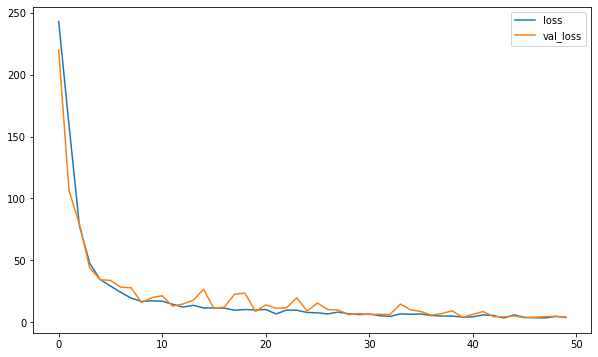

In [18]:
cnn_history_df[['loss', 'val_loss']].plot(figsize=(10,6))

<AxesSubplot:>

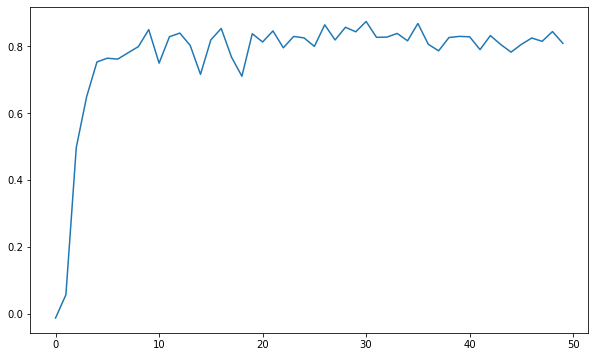

In [20]:
cnn_history_df['Pearson_r'].plot(figsize=(10,6))

## Model Testing

In [3]:
window = 250
best_model = load_model('models/prosup_velocity_model_{}_p86.hdf5'.format(window))
# best_model = load_model('best_model_reg.hdf5')

In [8]:
file = 'Subjects/Fazil/computed_Screw02.csv'
df = pd.read_csv(file,index_col=0)[29000:37000]#[72500:82500]#[4500:85000]#
df = filter_df([df])[0]

In [9]:
X, y = prep_data_velocity(df,window,interval=10,Normalize=True,rms=False,angle_label ='Pronation_Angle')

In [87]:
X_mean = np.load('mean_std_master.npy')[0]
X_std = np.load('mean_std_master.npy')[1]
X_new = []
for x in tqdm(X):
    X_new.append((x-X_mean)/X_std)
X = np.array(X_new)

25/25 [==============================] - 0s 6ms/step - loss: 29.4251


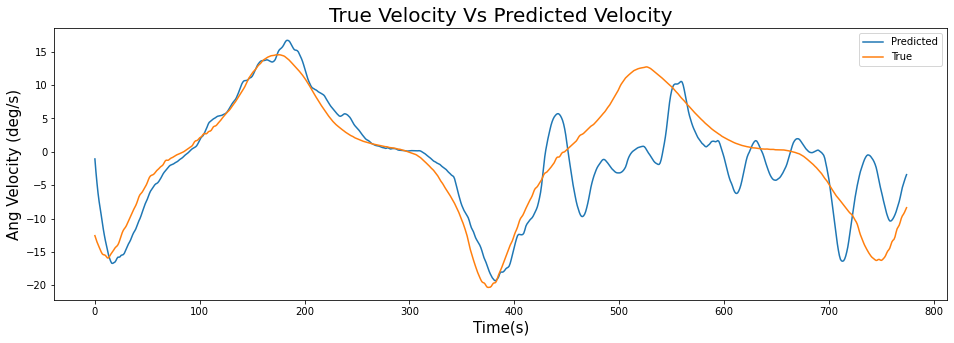

In [12]:
test_model = best_model
pred = test_model.predict(X)
test_model.evaluate(X,y)

plt.figure(figsize=(16,5))
pred = filter_array(pred,order=1,cf=50,fs=2000)
# y = filter_array(y,order=1,cf=100,fs=2000)
plt.plot(pred)
plt.plot(y)
plt.title('True Velocity Vs Predicted Velocity',size=20)
plt.ylabel('Ang Velocity (deg/s)',size=15)
plt.xlabel('Time(s)', size=15)
plt.legend(['Predicted', 'True'], loc='best')
plt.show()

In [13]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
print('MSE Loss -',mean_squared_error(y,pred))
print('RMSE -',mean_squared_error(y,pred,squared=False))
print('Pearson Correlation Coefficient -',pearsonr(y.flatten(),pred.flatten()))

MSE Loss - 26.586180203459417
RMSE - 5.156178837420151
Pearson Correlation Coefficient - (0.8170755998489332, 4.579530339918226e-187)


In [ ]:
# pearsonr 0.8

In [23]:
def correlation_coefficient_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(xm * ym)
    r_den = K.sum(K.sum(K.square(xm)) * K.sum(K.square(ym)))
    r = r_num / r_den
    return 1 - r**2


def correlation_coefficient(y_true, y_pred):
    pearson_r, update_op = tf.contrib.metrics.streaming_pearson_correlation(y_pred, y_true)
    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'correlation_coefficient' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        pearson_r = tf.identity(pearson_r)
        return 1-pearson_r**2
def pearson_r(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / r_den
    return K.mean(r)

In [18]:
system_sleep()

In [ ]:
system_shutdown()

In [14]:
class test_loss(tf.keras.callbacks.Callback):

    def __init__(self, X,y):
        super(test_loss, self).__init__()
        self.X_t = X
        self.y_t = y
        
    def on_epoch_end(self, epoch, logs={}):
        logs['Pearson_r'] = float('-inf')
        pred = self.model.predict(self.X_t)
        score = pearsonr(pred.flatten(),self.y_t.flatten())[0]
        logs['Pearson_r'] = np.round(score, 5)
        print('Pearson_r_Test= ',np.round(score, 5))

